# Analysis of existing installations
The goal of this notebook find new features that could help inestigating

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import pickle

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

## data loading
input:
- set of features from hubspot
- set of features and savings calculation from internal api
- daily aggregated values of cics
- cic production dataset, to link cic id to ordernumber

Output:
df_cic: 1 row is 1 day of data, all features of a cic(installation) are merged onto that frame

In [147]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [148]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_hubspot = pd.read_csv('./data/hubspot_data.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_hubspot['orderNr'] = df_hubspot['Deal Name'].str.extract(r'.*(QUATT\d+)')
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_savings = pd.merge(df_savings, df_hubspot, left_on='orderNr', right_on='orderNr', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')

# reformat date column
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')


In [207]:
temp_groups = df_cic[df_cic['number_of_rows']==24].groupby('cic_id').aggregate({'date': ['min', 'max'],
                                                                                'Aardgas':'first',
                                                                                'Woningtype':'first',
                                                                                'orderNumber':'first'})

In [208]:
temp_groups.columns = ['_'.join(col).strip() for col in temp_groups.columns.values]

# Step 2: Rename the columns
temp_groups = temp_groups.rename(columns={
    'date_min': 'min_date',
    'date_max': 'max_date',
    'Aardgas_first': 'Aardgas',
    'Woningtype_first': 'Woningtype',
    'orderNumber_first': 'orderNumber'
})



In [193]:
df_savings[df_savings['id_y']=='CIC-088e9508-019f-5236-9dc1-c3ebb4fbf81a']

,id_x,created_at,updated_at,deal_id,orderNr,aanbevolen_vermogen_warmtepomp,referentie_warmtevraag_per_m2,geschiktheid_woning,aardgas_verbruik,bouwjaar,...,Thermostaat,Thermostaat [Anders],Thermostaat type,Verwarmingsinstallatie,Vloerisolatie,Warmte,Woning comfort,Woningtype,Zolder verdieping,Zone regeling


In [204]:

temp_groups

,min_date,max_date,Aardgas,Woningtype
cic_id,,,,
CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-22,2023-10-02,NaN,None
CIC-0043864c-e94c-59d1-9f86-8193abf8878c,2023-07-29,2023-10-02,3400.0,Vrijstaand
CIC-0056683f-8a2f-5fe0-bb22-d8441ffa81f5,2023-09-21,2023-10-02,NaN,None
CIC-0084fc13-f765-505f-ac5f-ecfd36eab409,2023-03-25,2023-10-02,2300.0,2-onder-1-kap
CIC-008663f3-ae08-5865-a928-396b48d866b7,2023-07-19,2023-10-02,1700.0,Vrijstaand
...,...,...,...,...
CIC-ff9155b8-30a7-51ea-bad2-fee0ff5eacef,2023-09-25,2023-10-02,1200.0,2-onder-1-kap
CIC-ffaf7c21-d3e1-5c0f-b3d8-58d66613687f,2023-07-22,2023-10-02,1520.0,Vrijstaand
CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,2023-03-28,2023-10-02,1200.0,Tussenwoning


In [210]:
ans = temp_groups[(temp_groups['min_date']>'2023-09-22') &
            (temp_groups['max_date']<'2023-10-25') &
            (temp_groups['Aardgas'].notna())]
ans.to_csv('./data/smart_meter_testgroup.csv', index=False)

In [170]:
df_hubspot[['Aardgas','Woningtype','Afmetingen van het huis']].isna().sum()

Aardgas                    23
Woningtype                  3
Afmetingen van het huis     3
dtype: int64

### FROM knmi data ADD temperatures and radiation

In [149]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df_knmi = pd.DataFrame(columns=header, data=data)

# add date columns to dataset
df_knmi['date'] = pd.to_datetime(df_knmi['YYYYMMDD'], format='%Y%m%d')
df_knmi['TG'] = df_knmi['TG'].astype(float)/10
df_knmi['year'] = df_knmi['date'].dt.year
df_knmi['month'] = df_knmi['date'].dt.month
df_knmi['day'] = df_knmi['date'].dt.day
df_knmi['month-day'] = df_knmi['date'].dt.strftime('%m-%d')

# rename relevant columns
df_knmi = df_knmi.rename(columns={'TG':'knmi_avg_temp',
                                  'TN':'knmi_min_temp',
                                  'TX':'knmi_max_temp',
                                  'SQ':'knmi_sunshine_duration',
                                  'SP':'knmi_sunshine_percentage',
                                  'Q':'knmi_global_radiation'})

In [150]:
df_cic['date']

0        2023-03-17
1        2023-06-09
2        2023-06-10
3        2023-06-11
4        2023-06-12
            ...    
307214   2023-09-29
307215   2023-09-30
307216   2023-10-01
307217   2023-10-02
307218   2023-10-03
Name: date, Length: 307219, dtype: datetime64[ns]

In [151]:
df_cic = pd.merge(df_cic, 
                  df_knmi[['knmi_avg_temp',
                           'knmi_min_temp',
                           'knmi_max_temp',
                           'knmi_sunshine_duration',
                           'knmi_sunshine_percentage',
                           'knmi_global_radiation',
                           'date']],
                    on='date',
                    how='left')

## Enriching the data

Addition of calculated values: COP, heat generated etc.  



In [152]:


# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_heat_generated'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_energy_consumed'] = df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1).astype(float)
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1)) # month weight factor as used in degree days method
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

## preprocessing

Imputation: 
- Missing values: numberOfHeatPumps = 1, 'Zone regeling'=Nee  

Merging values:
- Weet niet, weet ik niet, none -> unknown
- Bouwjaar in 4 categories

Ordinal encoding:
- added ordinal encoding column for woning_type, zone_regeling, bouwjaar

One hot encoding:
- added OH encoding for afgiftesysteem, woningcomfort (because they can have multiple values)

In [153]:
# filling Nan values
df_cic['numberOfHeatPumps'].fillna(1, inplace=True)
df_cic['Zone regeling'].fillna('Nee', inplace=True)

# preprocess hubspot data
# merge 'Weet niet' and 'Weet ik niet' and 'nan' values to -> unkown
replacement_dict = {None: 'unknown', 
                    'Weet niet': 'unknown',
                    'Weet ik niet': 'unknown'}
df_cic.replace({'Spouwmuurisolatie': replacement_dict,
                    'Muurisolatie aan de binnen- of buitenkant': replacement_dict,
                    'Dakisolatie': replacement_dict,
                    'Vloerisolatie': replacement_dict,
                    'Dubbel glas': replacement_dict,
                    'HR++ glas': replacement_dict,
                    }, inplace=True)

# rename long column
df_cic.rename(columns={'Muurisolatie aan de binnen- of buitenkant': 'Muurisolatie'}, inplace=True)

# add ordinal encoding for categorical variables
df_cic['woning_type_ordinal'] = df_cic['woning_type'].map({'Vrijstaande woning': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

df_cic['Zone_regeling_ordinal'] = df_cic['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

df_cic['bouwjaar'] = df_cic['bouwjaar'].map({'Voor 1970': 'Voor 1970',
                                            'voor 1970': 'Voor 1970',
                                            'Tussen 1970 en 1990': 'Tussen 1970 en 1990',
                                            '1970-1990': 'Tussen 1970 en 1990',
                                            '1974': 'Tussen 1970 en 1990',
                                            '1980': 'Tussen 1970 en 1990',
                                            'Tussen 1990 en 2000': 'Tussen 1990 en 2000',
                                            'Tussen 1995': 'Tussen 1990 en 2000',
                                            'Na 2000': 'Na 2000',
                                            '2000': 'Na 2000',
                                            '2005': 'Na 2000',
                                            '2010': 'Na 2000'})
df_cic['bouwjaar_ordinal'] = df_cic['bouwjaar'].map({'Voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Na 2000': 3})

# One hot encoding for categorical variables with multiple values
df_cic = pd.merge(df_cic, df_cic['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
df_cic = pd.merge(df_cic, df_cic['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)


## visualisation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


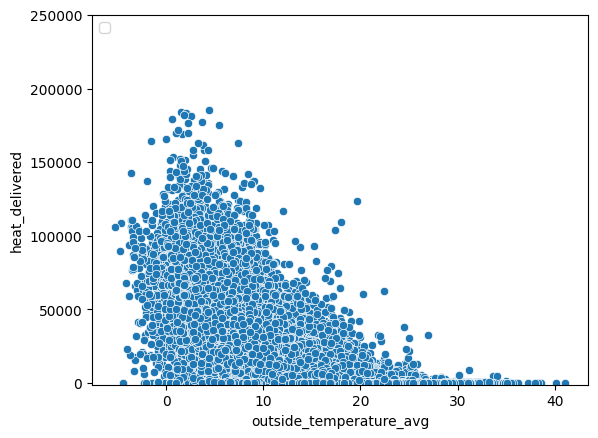

In [6]:


# scatter plot of heat demand per temperature including linear regression
sns.scatterplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic)
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

(-0.1, 1.1)

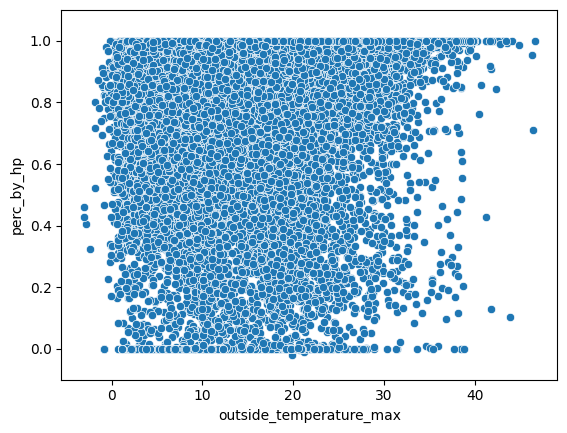

In [7]:
# scatter plot of perc_by_hp per temperature
sns.scatterplot(x='outside_temperature_max', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000])
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

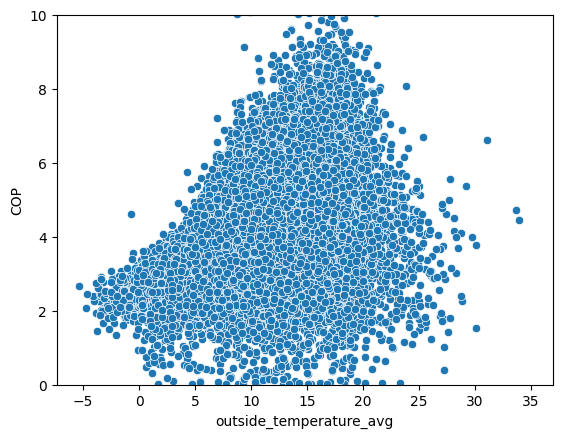

In [8]:
# scatter plot of COP per temperature
COP_temp = sns.scatterplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)])
plt.ylim([0,10])

## Cleaning of data
- Selecting a subset of features (columns)
- select a set of cics for which days of heating > 50
- select those where certain values are not zero

In [154]:
# drop certain testing cic's
cic_blacklist = ['CIC-f42058e3-44c5-5d70-809d-f2ee78b2abf9',
                'CIC-46f31f71-9b6d-5af5-ba63-1c71d639dcc5',
                'CIC-691989e5-24b7-59b9-9807-537c89035f25',
                'CIC-33d8a5ac-84da-5531-9f93-dc3a3d2635bc',
                'CIC-b456cd2e-d054-5314-96e0-c06e38aac609',
                'CIC-9b02a27b-1a6a-594b-94d1-0373d32c1977',
                'CIC-ab5dd581-df24-580e-b5c0-f80919325d5d']
df_cic.drop(df_cic[df_cic['cic_id'].isin(cic_blacklist)].index, inplace=True)

In [155]:
# drop rows that are compiled of inclomplete data (get rid of commissioning)
df_cic.drop(df_cic[df_cic['number_of_rows']<24].index, inplace=True)
# df_cic.drop(df_cic[(df_cic['hp1_active']==0) & 
#                    (df_cic['hp2_active']==0) & 
#                    (df_cic['boiler_active']==0) & 
#                    (df_cic['heat_delivered']>0)].index, inplace=True)
# df_cic[(df_cic['hp1_active']==0) & (df_cic['hp2_active'].isna()) & (df_cic['hp1_heat_generated']>0)]

In [156]:
# calculate roomtemperature setpoint estimates
df_roomtemp_setpoints = (df_cic[(df_cic['heat_delivered']>1000)]
                         .groupby('cic_id')
                         .aggregate({'room_set_temperature_max': 'median',
                                    'room_set_temperature_avg': 'median',
                                    'room_set_temperature_min': 'median'})
)
# rename columns
df_roomtemp_setpoints.rename(columns={'room_set_temperature_max': 'room_set_temperature_max_median',
                                        'room_set_temperature_avg': 'room_set_temperature_avg_median',
                                        'room_set_temperature_min': 'room_set_temperature_min_median'}, inplace=True)

# merge setpoints onto df_cic
df_cic = pd.merge(df_cic, df_roomtemp_setpoints, left_on='cic_id', right_on='cic_id', how='left')

# drop rows with no room temperature setpoint
df_cic.drop(df_cic[df_cic['room_set_temperature_max_median'].isna()].index, inplace=True)

In [ ]:
# add median max heating temperature at days where heating as 'standard setpoint' 
# setpoint_estimates = df_cic_subset[df_cic_subset['heat_delivered']>0].groupby('cic_id')['room_set_temperature_max'].median().reset_index()
# setpoint_estimates.rename(columns={'room_set_temperature_max':'setpoint_estimate'}, inplace=True)
# df_cic_subset = pd.merge(df_cic_subset, setpoint_estimates, on='cic_id', how='left')

In [157]:
df_cic

,cic_id,created_at_x,updated_at_x,date,hp1_energy_consumed,hp1_heat_generated,hp1_active,hp2_energy_consumed,hp2_heat_generated,hp2_active,...,Radiatoren,Vloerverwarming,Goed,Soms te koud,Soms te warm,Vaak te koud,Vaak te warm,room_set_temperature_max_median,room_set_temperature_avg_median,room_set_temperature_min_median
113,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-26 11:25:44,2023-09-26 11:25:44,2023-09-22,1697.866817,10216.930725,0.25,1581.109437,8824.805910,0.25,...,0,0,0,0,0,0,0,21.0,18.736,16.0
114,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-26 11:25:44,2023-09-26 11:25:44,2023-09-23,2035.810868,8994.292393,0.21,1992.698456,9812.421224,0.21,...,0,0,0,0,0,0,0,21.0,18.736,16.0
115,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-26 11:25:44,2023-09-28 12:49:32,2023-09-25,474.417543,2642.555604,0.09,534.052625,2651.662607,0.09,...,0,0,0,0,0,0,0,21.0,18.736,16.0
116,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-28 12:49:32,2023-09-28 12:49:32,2023-09-26,497.021151,2416.305201,0.09,643.365503,3849.582055,0.09,...,0,0,0,0,0,0,0,21.0,18.736,16.0
117,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-09-28 12:49:32,2023-10-03 13:10:59,2023-09-28,1884.536833,9244.147697,0.15,2429.232167,10810.864416,0.15,...,0,0,0,0,0,0,0,21.0,18.736,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289698,CIC-ffe56568-3bf3-5943-ac2c-ad4461aa6144,2023-09-28 13:10:52,2023-10-03 13:32:09,2023-09-28,127.587220,0.000000,0.00,NaN,NaN,NaN,...,0,1,1,1,0,0,0,20.5,20.084,19.5
289699,CIC-ffe56568-3bf3-5943-ac2c-ad4461aa6144,2023-10-03 13:32:09,2023-10-03 13:32:09,2023-09-29,126.738668,0.000000,0.00,NaN,NaN,NaN,...,0,1,1,1,0,0,0,20.5,20.084,19.5
289700,CIC-ffe56568-3bf3-5943-ac2c-ad4461aa6144,2023-10-03 13:32:09,2023-10-03 13:32:09,2023-09-30,1013.494336,4769.562680,0.09,NaN,NaN,NaN,...,0,1,1,1,0,0,0,20.5,20.084,19.5
289701,CIC-ffe56568-3bf3-5943-ac2c-ad4461aa6144,2023-10-03 13:32:09,2023-10-03 13:32:09,2023-10-01,1247.416383,6687.917881,0.12,NaN,NaN,NaN,...,0,1,1,1,0,0,0,20.5,20.084,19.5


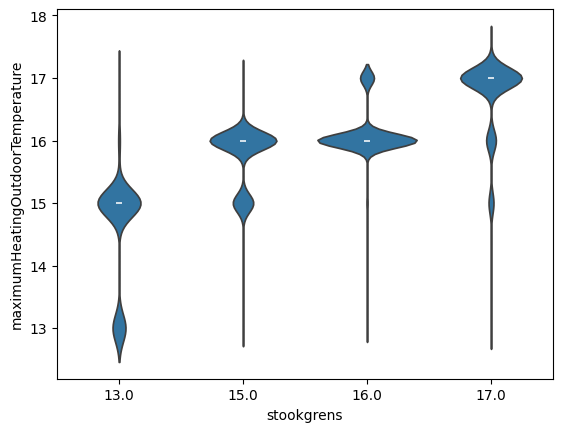

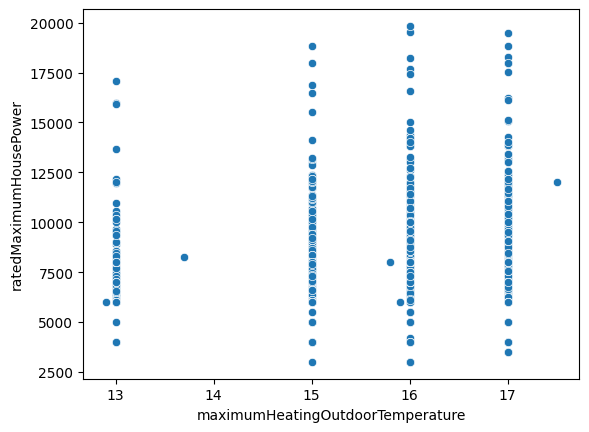

In [11]:
# print(df_cic.columns.values)

df_cic_facts = df_cic.groupby('cic_id').aggregate({'stookgrens': 'median',
                                                   'maximumHeatingOutdoorTemperature': 'median',
                                                   'ratedMaximumHousePower': 'median'})
# mamximumHeatingOutdoorTemperature, ratedMaximumHousePower, stookgrens
# sns.scatterplot(data=df_cic, x='stookgrens', y='maximumHeatingOutdoorTemperature', hue='ratedMaximumHousePower')

# boxplot of same parameters
sns.violinplot(data=df_cic_facts, x='stookgrens', y='maximumHeatingOutdoorTemperature')
plt.show()

sns.scatterplot(data=df_cic_facts, x='maximumHeatingOutdoorTemperature', y='ratedMaximumHousePower')
plt.show()

In [12]:
df_cic['usePricingToLimitHeatPump'].isna().sum() # what value is used for missing values?

32308

In [13]:
df_cic[df_cic['aardgas_verbruik'] != df_cic['Aardgas']][['cic_id','Aardgas','aardgas_verbruik']].value_counts()

cic_id                                    Aardgas  aardgas_verbruik
CIC-b0dcac9c-0352-5406-8eb2-621bdd2c62c5  2500.0   2000.0              137
dtype: int64

In [14]:
df_cic[(df_cic['heat_delivered']>0) &
       # (df_cic['outside_temperature_avg']>20) &
       (df_cic['room_set_temperature_max']<df_cic['room_temperature_min'])
       ][[
           'cic_id',
           'heat_delivered',
           'outside_temperature_avg',
           'outside_temperature_avg',
       'outside_temperature_min',
       'outside_temperature_max',
       'room_set_temperature_max',
       'room_set_temperature_avg',
       'room_set_temperature_min',
       'room_temperature_max',5d
       'room_temperature_avg',
       'room_temperature_min']]

,cic_id,heat_delivered,outside_temperature_avg,outside_temperature_avg,outside_temperature_min,outside_temperature_max,room_set_temperature_max,room_set_temperature_avg,room_set_temperature_min,room_temperature_max,room_temperature_avg,room_temperature_min
32,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,1.359693,26.775,26.775,16.818,40.552,19.000,18.646,18.0,26.286,25.502,24.997
41,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,1.069653,22.387,22.387,16.483,33.506,19.000,18.646,18.0,25.101,24.880,24.599
57,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,10.744160,19.367,19.367,14.375,27.803,19.000,18.646,18.0,23.813,23.164,22.755
67,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,0.913699,23.128,23.128,15.194,32.882,19.000,18.646,18.0,24.731,24.026,23.341
92,CIC-00149d9a-da31-5e61-844d-3e818b8a2ded,27.706255,27.179,27.179,18.238,41.246,19.000,18.646,18.0,26.187,25.571,24.916
...,...,...,...,...,...,...,...,...,...,...,...,...
306712,CIC-ffaf7c21-d3e1-5c0f-b3d8-58d66613687f,1202.952756,16.785,16.785,13.517,20.542,19.726,18.655,18.0,21.629,21.382,21.140
306776,CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,999.967758,9.267,9.267,8.358,10.734,17.219,16.852,16.0,18.870,17.998,17.609
306787,CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,2566.030873,10.504,10.504,4.213,14.820,16.000,16.000,16.0,17.148,16.667,16.177
307055,CIC-ffd4679f-365a-5536-8817-62509ce33977,1051.333755,16.659,16.659,14.496,19.919,20.316,18.628,18.0,21.868,21.597,21.449


In [145]:
df_roomtemp_setpoints = (df_cic[(df_cic['heat_delivered']>1000)]
                         .groupby('cic_id')
                         .aggregate({'room_set_temperature_max': 'median',
                                    'room_set_temperature_avg': 'median',
                                    'room_set_temperature_min': 'median'})
)
print(len(df_roomtemp_setpoints['room_set_temperature_max']))
# df_roomtemp_setpoints['room_set_temperature_max'].hist(bins=150)
# plt.show()
# df_roomtemp_setpoints['room_set_temperature_avg'].hist(bins=150)
# plt.show()
# df_roomtemp_setpoints['room_set_temperature_min'].hist(bins=150)
# plt.show()
df_roomtemp_setpoints

1988


,room_set_temperature_max,room_set_temperature_avg,room_set_temperature_min
cic_id,,,
CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,21.000,18.7360,16.000
CIC-0043864c-e94c-59d1-9f86-8193abf8878c,21.000,21.0000,21.000
CIC-0056683f-8a2f-5fe0-bb22-d8441ffa81f5,19.500,18.2550,16.500
CIC-0084fc13-f765-505f-ac5f-ecfd36eab409,20.000,18.8330,17.676
CIC-008663f3-ae08-5865-a928-396b48d866b7,22.000,17.1430,14.500
...,...,...,...
CIC-ff9155b8-30a7-51ea-bad2-fee0ff5eacef,19.000,16.1710,15.000
CIC-ffaf7c21-d3e1-5c0f-b3d8-58d66613687f,21.363,19.0645,18.000
CIC-ffd3bdd6-fd98-54cc-ab62-6a89aa0e16fd,20.000,17.4740,16.000


In [131]:
len(df_cic[(df_cic['heat_delivered']>0)]['cic_id'].unique())

2254

In [138]:
# get a subset of cic_data with cic's that have enough rows with non zero heat generated
df_cic_subset = df_cic[['cic_id',
                        'maximumHeatingOutdoorTemperature',
                        'ratedMaximumHousePower',
                        'date',
                        'heat_delivered',
                        'hp_heat_generated',
                        'hp_energy_consumed',
                        'perc_by_hp',
                        'COP',
                        'outside_temperature_avg',
                        'outside_temperature_min',
                        'outside_temperature_max',
                        'room_set_temperature_max',
                        'room_set_temperature_avg',
                        'room_set_temperature_min',
                        'room_temperature_max',
                        'room_temperature_avg',
                        'room_temperature_min',
                        'numberOfHeatPumps',
                        'aardgas_verbruik',
                        'bouwjaar',
                        'woning_type',
                        'oppervlakte',
                        'afgiftesysteem',
                        'geschiktheidscategorie',
                        'Zone regeling',
                        'month']]

# add count of rows where heat_delivered > 0 per cic
df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())
df_cic_subset = df_cic_subset[df_cic_subset['rows_per_cic_heating']>50]
# drop rows where tempearature avg is nan
df_cic_subset = df_cic_subset[df_cic_subset['outside_temperature_avg'].notna()]

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_93073/43802628.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_subset['rows_per_cic_heating'] = df_cic_subset.groupby('cic_id')['heat_delivered'].transform(lambda x: x[x>0].count())


## select data to train model

In [158]:
# copy only rows with correct features
X = (df_cic[
        (df_cic['outside_temperature_avg']<16) &
      #   (df_cic['aardgas_verbruik']>100) &
      #   (df_cic['aardgas_verbruik']<6000) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna())]
                                  # feature list
                                  [[
                                      # features from cic measurements
                                      # 'outside_temperature_avg',
                                      # 'outside_temperature_min',
                                      # 'outside_temperature_max',
                                      'room_set_temperature_max_median',
                                      'room_set_temperature_avg_median',
                                      'room_set_temperature_min_median',
                                      # 'room_temperature_max',
                                      # 'room_temperature_avg',
                                      # 'room_temperature_min',
                                      'month',
                                      # features from cic data
                                      'numberOfHeatPumps',
                                      # features from savings calc.
                                      'referentie_warmtevraag_per_m2',
                                      # 'geschiktheid_woning',  # remove
                                      'aardgas_verbruik',
                                      'bouwjaar',
                                      'woning_type',
                                      'oppervlakte',
                                      'afgiftesysteem',
                                      'geschiktheidscategorie',  # remove
                                      'referentie_warmtevraag',
                                      'stookgrens',  # remove
                                      # features from hubspot
                                      'Spouwmuurisolatie',
                                      'Muurisolatie',
                                      'Dakisolatie',
                                      'Vloerisolatie',
                                      'Dubbel glas',
                                      'HR++ glas',
                                      'Zone regeling',
                                      'Woning comfort',
                                      'Elektriciteit',
                                      # features from knmi
                                      'knmi_avg_temp',
                                      'knmi_min_temp',
                                      'knmi_max_temp',
                                      'knmi_sunshine_duration',
                                      'knmi_sunshine_percentage',
                                      'knmi_global_radiation'
                                      ]]
)



# select target variable
hp_heat_generated =  (df_cic[
                    (df_cic['outside_temperature_avg']<16) &
                  #   (df_cic['aardgas_verbruik']>100) &
                  #   (df_cic['aardgas_verbruik']<6000) &
                    (df_cic['outside_temperature_avg'].notna()) &
                    (df_cic['Elektriciteit'].notna())]
                                              [['hp_heat_generated']]
)

hp_energy_consumed =  (df_cic[
                      (df_cic['outside_temperature_avg']<16) &
                    #   (df_cic['aardgas_verbruik']>100) &
                    #   (df_cic['aardgas_verbruik']<6000) &
                      (df_cic['outside_temperature_avg'].notna()) &
                      (df_cic['Elektriciteit'].notna())]
                                                [['hp_energy_consumed']]
)

# replacing negative values can be needed for some model types
# y = np.max([y, np.zeros(y.shape)], axis=0) # replace negative values with 0

In [159]:
# handling categorical features
# impute nan values in categorical features


# Ordinal encoding
X['woning_type_ordinal'] = X['woning_type'].map({'Vrijstaand': 0,
                                         '2-onder-1-kap': 1,
                                         'Hoekwoning': 2,
                                         'Tussenwoning': 3,
                                         'Appartement': 4})

X['Zone_regeling_ordinal'] = X['Zone regeling'].map({'Nee': 0,
                                             'Ja': 1,
                                             None: 0})

X['bouwjaar_ordinal'] = X['bouwjaar'].map({'Voor 1970': 0,
                                   'voor 1970': 0,
                                   'Tussen 1970 en 1990': 1,
                                   '1970-1990': 1,
                                   '1974': 1,
                                   '1980': 1,
                                   'Tussen 1990 en 2000': 2,
                                   'Tussen 1995': 2,
                                   'Na 2000': 3,
                                   '2000': 3,
                                   '2005': 3,
                                   '2010': 3})

# isolation parameters to ordinal encoding
ordinal_mapping = {
    'unknown': 0,
    'Nee': 1, 
    'Ja (meer dan 10 jaar geleden geplaatst)': 2, 
    'Ja (minder dan 10 jaar geleden geplaatst)': 3
}

ordinal_columns = ['Spouwmuurisolatie', 'Muurisolatie', 'Dakisolatie', 'Vloerisolatie', 'Dubbel glas', 'HR++ glas']

for column in ordinal_columns:
    X[column] = X[column].fillna('unknown').map(ordinal_mapping)


# 1 hot encode categorical features
X = pd.merge(X, X['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
X = pd.merge(X, X['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)

# X = pd.merge(X, pd.get_dummies(X[[
#                                   'geschiktheidscategorie',
#                                   'stookgrens'
#                                   ]].astype(str)), 
#                                   left_index=True, right_index=True)
# X = pd.merge(X, pd.get_dummies(X[[
#                                   # 'geschiktheid_woning',
#                                 #   'bouwjaar',
#                                 #   'woning_type',
#                                   # 'Spouwmuurisolatie',
#                                   # 'Muurisolatie',
#                                   # 'Dakisolatie',
#                                   # 'Vloerisolatie',
#                                   # 'Dubbel glas',
#                                   # 'HR++ glas',
#                                   # 'Zone regeling'
#                                   ]]), 
#                                   left_index=True, right_index=True)



# remove categorical features
X = X.drop(['afgiftesysteem',
            # 'geschiktheid_woning',
            'bouwjaar',
            'woning_type',
            # 'Spouwmuurisolatie',
            # 'Muurisolatie',
            # 'Dakisolatie',
            # 'Vloerisolatie',
            # 'Dubbel glas',
            # 'HR++ glas',
            'Zone regeling',
            'Woning comfort',
            # 'geschiktheidscategorie',
            # 'stookgrens'
            ], axis=1)

# rename long columns names
# X.columns = X.columns.str.replace(r"(.*)Ja \(meer dan 10 jaar geleden geplaatst\)", r"\1Ja >10")
# X.columns = X.columns.str.replace(r"(.*)Ja \(minder dan 10 jaar geleden geplaatst\)", r"\1Ja <10")


In [160]:
# merge frames and export to csv
df_total = pd.merge(X, hp_heat_generated, left_index=True, right_index=True)
df_total = pd.merge(df_total, hp_energy_consumed, left_index=True, right_index=True)
df_total = df_total.dropna(axis=0)
# df_total.to_csv('./data/export/12degree.csv', index=False)

# split df_total back into X and y
X = df_total.drop(['hp_heat_generated','hp_energy_consumed'], axis=1)
hp_heat_generated = df_total[['hp_heat_generated']]
hp_energy_consumed = df_total[['hp_energy_consumed']]

## visualize heat generated temperature and month dependency

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_22518/3960069833.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=df_cic, # [df_cic['month'].isin([5, 6, 7, 8, 9, 10])]


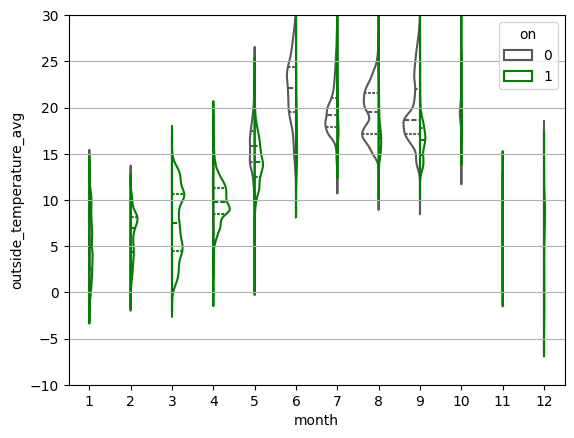

In [37]:
# histogram of average temperature split per month
# violin plot of average temperature split per month
df_cic['on'] = df_cic['heat_delivered'].apply(lambda x: 1 if x > 0 else 0)

sns.violinplot(data=df_cic, # [df_cic['month'].isin([5, 6, 7, 8, 9, 10])]
                x='month',
                y='outside_temperature_avg',
                hue='on', split=True, fill=False, inner='quartile',
                scale='count',
                palette={1: "g", 0: ".35"})
plt.ylim([-10, 30])
plt.grid(axis='y')
#change figure size
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

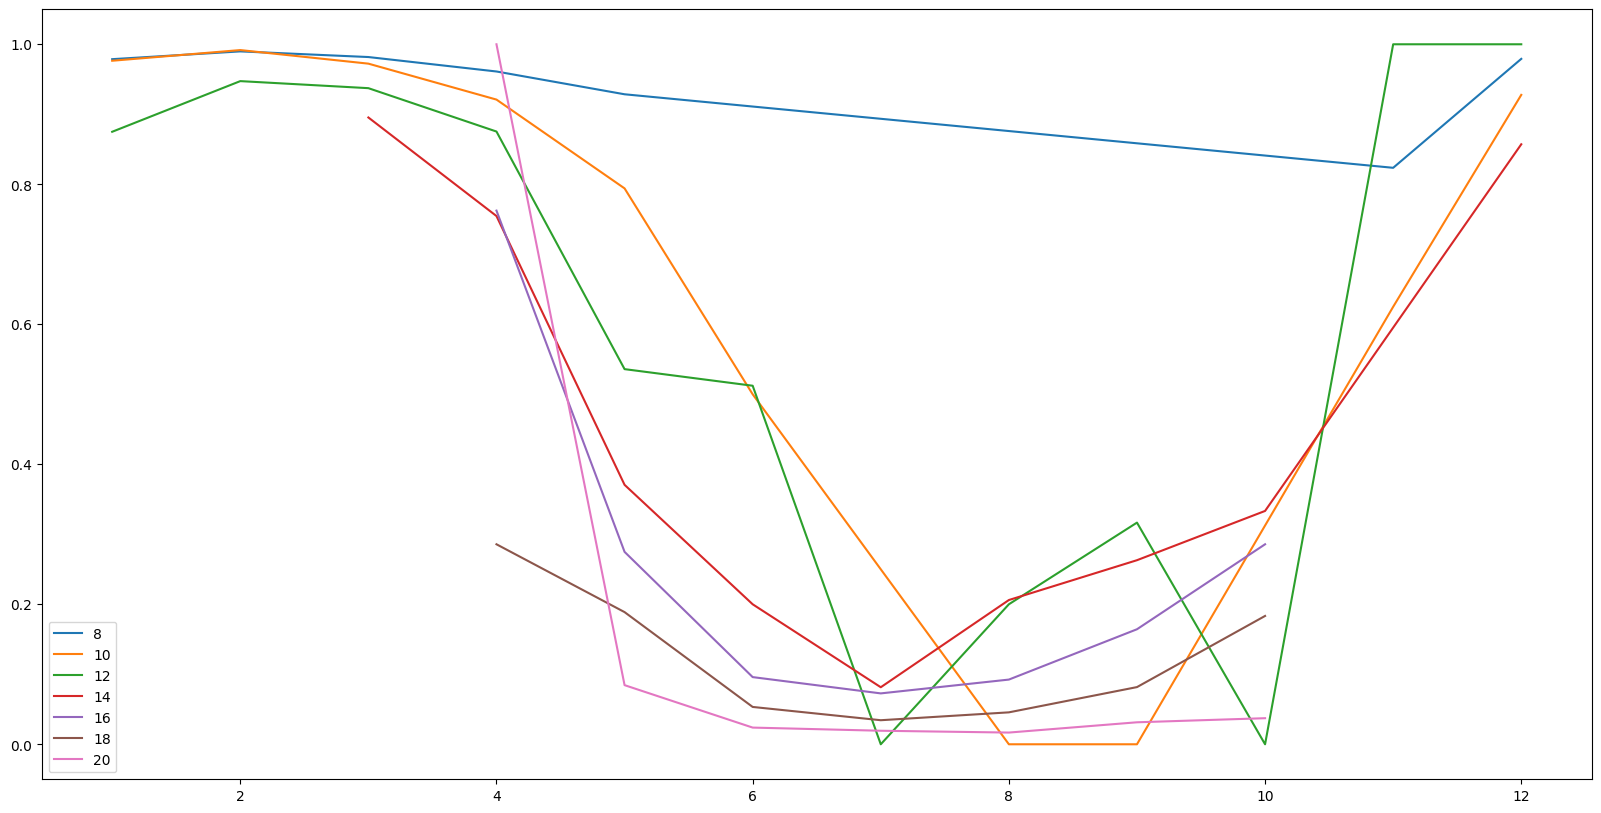

In [38]:
# 
for temp in range(8, 22, 2):
    plt.plot(df_cic[df_cic['outside_temperature_avg'].round(0) == temp].groupby('month').aggregate({'on': 'mean'}))
plt.legend(range(8, 22, 2))
plt.show()

# df_cic[df_cic['outside_temperature_avg'].round(0) == 15].groupby('month').aggregate({'on': 'mean', 'outside_temperature_avg': 'mean', 'heat_delivered': 'mean', 'cic_id':'count'})

In [20]:
# replace cic ids
df_cic['cic_id'] = df_cic['cic_id'].astype('category').cat.codes

In [21]:
df_cic[df_cic['month']==5]['on'].value_counts()

0    18037
1     8656
Name: on, dtype: int64

In [22]:
df_cic.to_csv('./data/export/df_cic.csv', index=False)

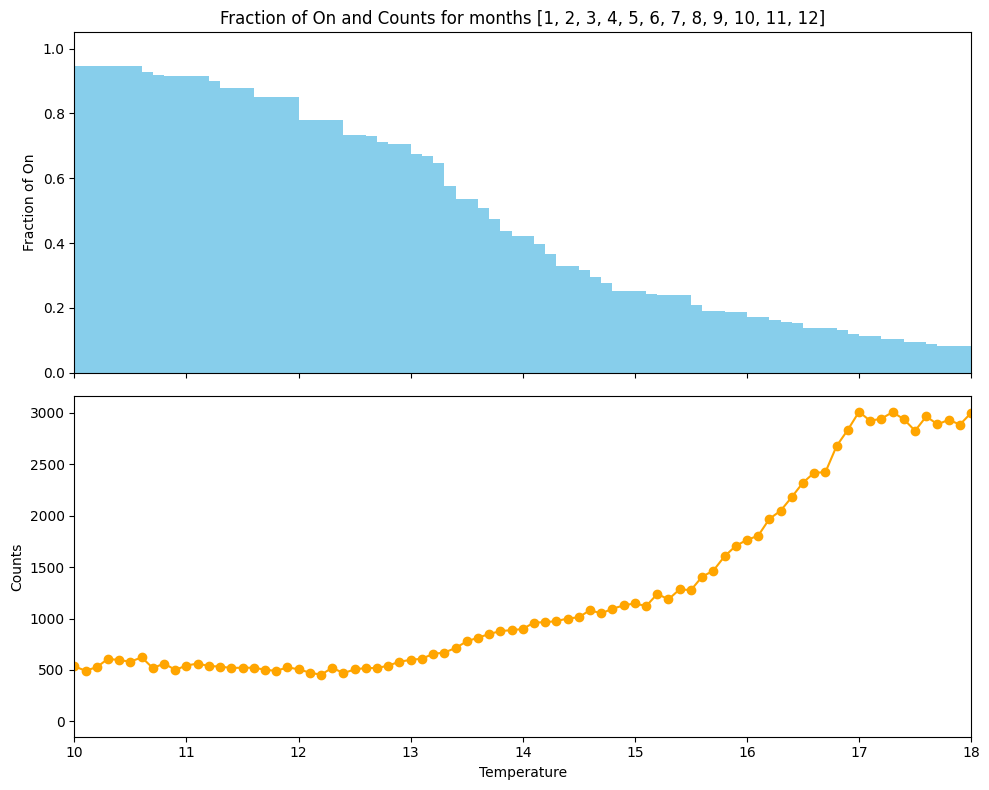

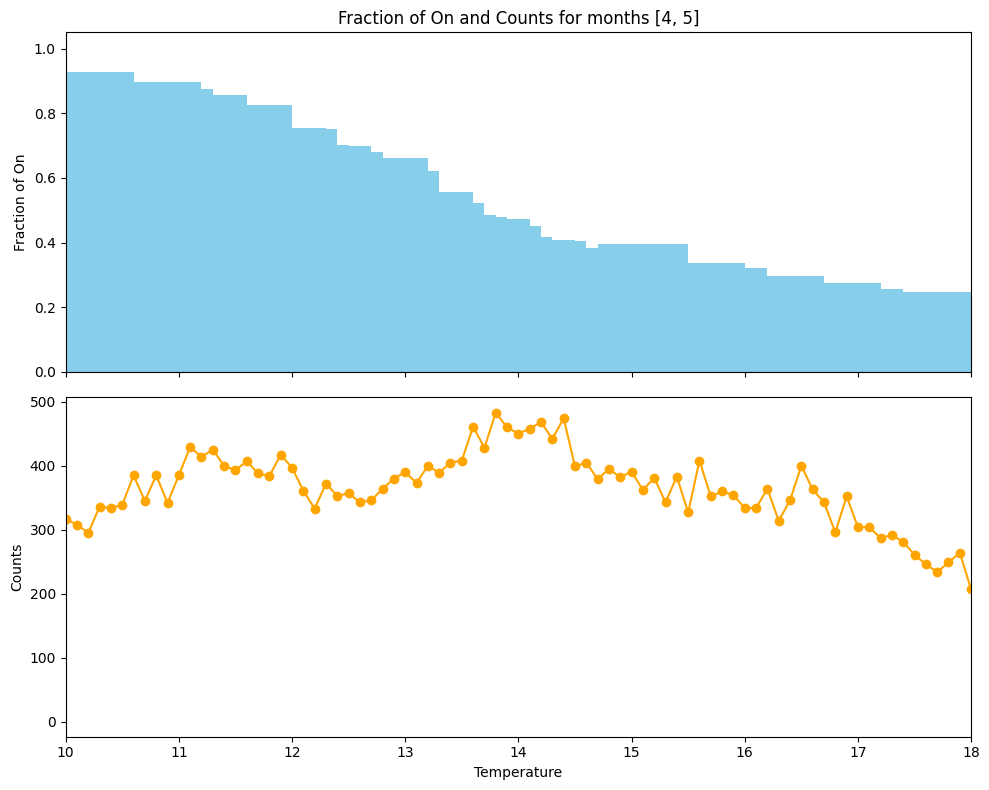

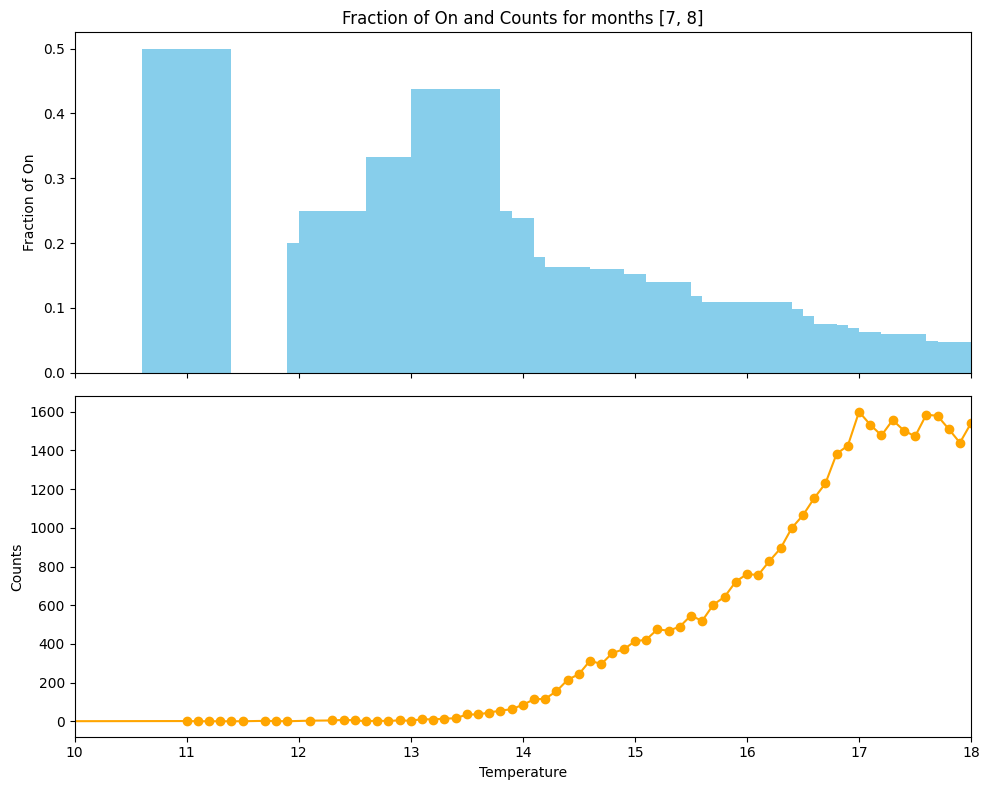

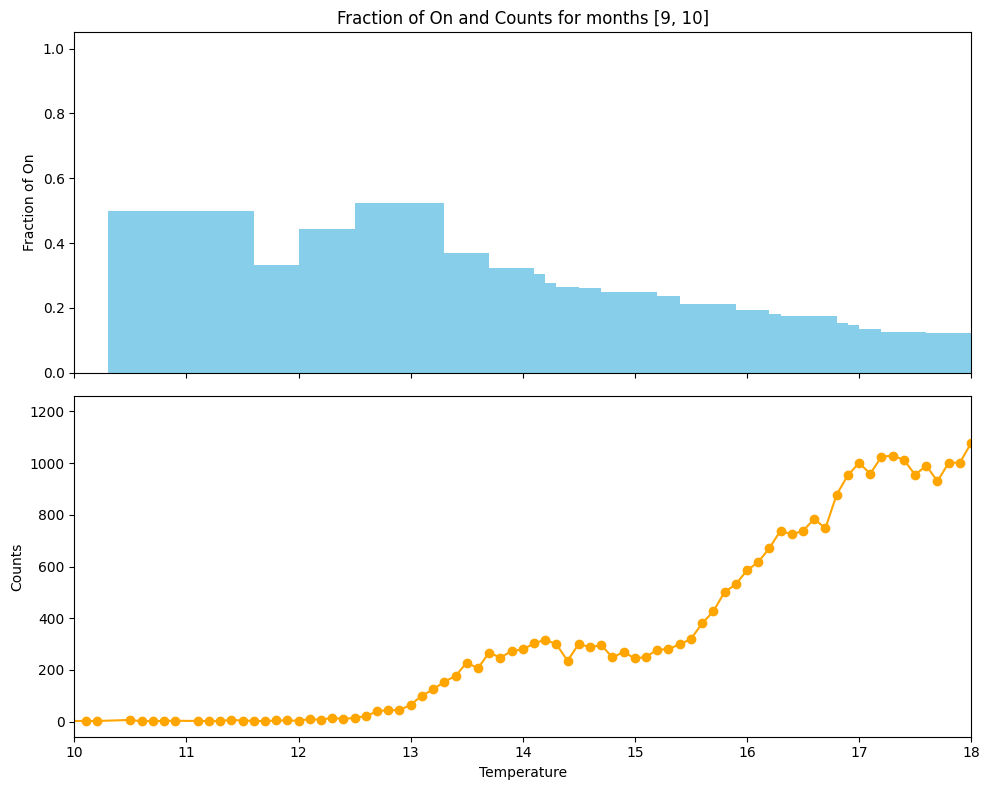

In [42]:
# group by rounded average temperature
df_cic['outside_temperature_avg_round'] = df_cic['outside_temperature_avg'].round(1)

# histogram of % of rows which is    on per temperature

# plt.plot(df_cic[df_cic['month'] == 9].groupby('outside_temperature_avg_round').count())
# plt.show()


# plt.plot(df_cic[df_cic['month'] == 5].groupby('outside_temperature_avg_round').filter().aggregate({'on': 'mean'}))
# plt.show()

def plot_on_fraction_for_months(df, months):
    # Filter dataframe for the given months
    df_subset = df[df['month'].isin(months)]
    
    # Group by temperature and calculate mean of 'on' and count
    grouped = df_subset.groupby('outside_temperature_avg_round').agg({'on': ['mean', 'size']}).reset_index()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Bar plot for fraction of 'on'
    ax[0].bar(grouped['outside_temperature_avg_round'], grouped[('on', 'mean')], color='skyblue')
    ax[0].set_ylabel('Fraction of On')
    ax[0].set_title(f'Fraction of On and Counts for months {months}')
    
    # Line plot for count of entries
    ax[1].plot(grouped['outside_temperature_avg_round'], grouped[('on', 'size')], color='orange', marker='o')
    ax[1].set_xlabel('Temperature')
    ax[1].set_ylabel('Counts')
    
    plt.xlim([10,18])
    plt.tight_layout()
    plt.show()

plot_on_fraction_for_months(df_cic, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plot_on_fraction_for_months(df_cic, [4, 5])
plot_on_fraction_for_months(df_cic, [7, 8])
plot_on_fraction_for_months(df_cic, [9, 10])

In [58]:
df_cic[(df_cic['outside_temperature_avg']>14.8) &(df_cic['outside_temperature_avg']<15.2)].groupby('month').aggregate({'on': 'mean'})['on']

month
3     0.888889
4     0.692308
5     0.326226
6     0.178117
7     0.105023
8     0.134615
9     0.216535
10    0.000000
12    1.000000
Name: on, dtype: float64

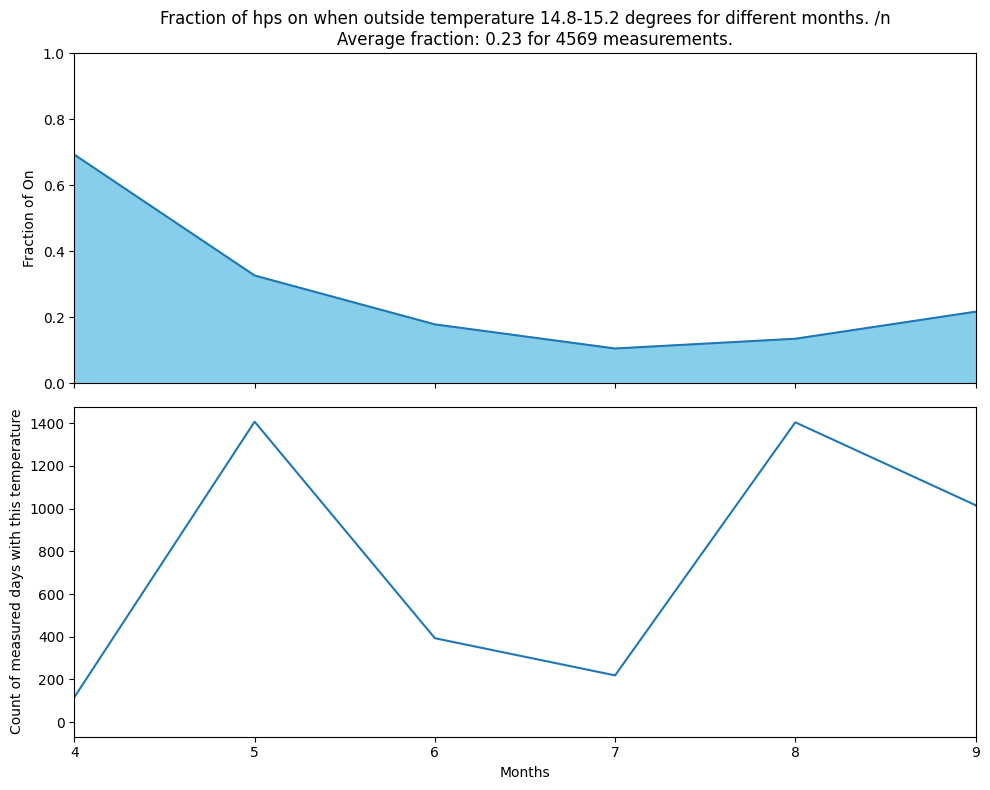

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
# Bar plot for fraction of 'on'
# fill area below line
ax[0].fill_between(df_cic[(df_cic['outside_temperature_avg']>14.8) &
            (df_cic['outside_temperature_avg']<15.2)]
            .groupby('month').aggregate({'on': 'mean'}).index,
            df_cic[(df_cic['outside_temperature_avg']>14.8) &
            (df_cic['outside_temperature_avg']<15.2)]
            .groupby('month').aggregate({'on': 'mean'})['on'],
            color='skyblue')
ax[0].plot(df_cic[(df_cic['outside_temperature_avg']>14.8) & 
            (df_cic['outside_temperature_avg']<15.2)]
            .groupby('month').aggregate({'on': 'mean'}))
ax[0].set_ylabel('Fraction of On')
ax[0].set_title(f'''Fraction of hps on when outside temperature 14.8-15.2 degrees for different months. /n
    Average fraction: {
    df_cic[(df_cic['outside_temperature_avg']>14.8) &
            (df_cic['outside_temperature_avg']<15.2)]['on'].mean()
        :.2f} for {
            len(df_cic[(df_cic['outside_temperature_avg']>14.8) &
            (df_cic['outside_temperature_avg']<15.2)])
            } measurements.''')
ax[0].set_ylim([0,1])

# Line plot for count of entries
ax[1].plot(df_cic[(df_cic['outside_temperature_avg']>14.8) & 
            (df_cic['outside_temperature_avg']<15.2)]
            .groupby('month').aggregate({'on': 'size'}))
ax[1].set_xlabel('Months')
ax[1].set_ylabel('Count of measured days with this temperature')

plt.xlim([4,9])
plt.tight_layout()
plt.show()

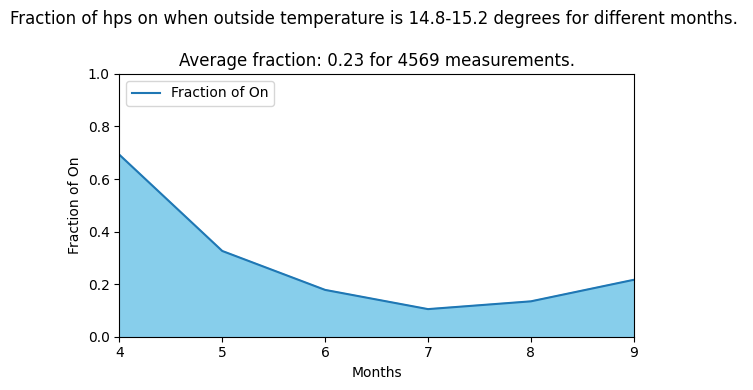

In [73]:
fig, ax1 = plt.subplots(figsize=(6, 4))

# Bar plot for fraction of 'on' (Fill area below line)
filtered_df = df_cic[(df_cic['outside_temperature_avg'] > 14.8) & (df_cic['outside_temperature_avg'] < 15.2)]
fraction_on = filtered_df.groupby('month').aggregate({'on': 'mean'})

ax1.fill_between(fraction_on.index, 
                 0, 
                 fraction_on['on'], 
                 color='skyblue')
ax1.plot(fraction_on.index, fraction_on['on'], label='Fraction of On')
ax1.set_ylabel('Fraction of On')
ax1.set_ylim([0,1])
ax1.set_title(f'''Fraction of hps on when outside temperature is 14.8-15.2 degrees for different months. \n
Average fraction: {
filtered_df['on'].mean():.2f} for {len(filtered_df)} measurements.''')

# Line plot for count of entries on a secondary y-axis
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# counts = filtered_df.groupby('month').aggregate({'on': 'size'})
# ax2.plot(counts.index, counts['on'], color='orange', label='Count of measured days')
# ax2.set_ylabel('Count of measured days with this temperature')

# To make the graph more readable, set a legend
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

ax1.set_xlabel('Months')
plt.xlim([4,9])
plt.tight_layout()
plt.show()


## plot correlation matrix of features

In [ ]:
# plot correlation matrix
corr = df_total.corr().stack().reset_index(name="correlation")


g = sns.relplot(
    data=corr,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

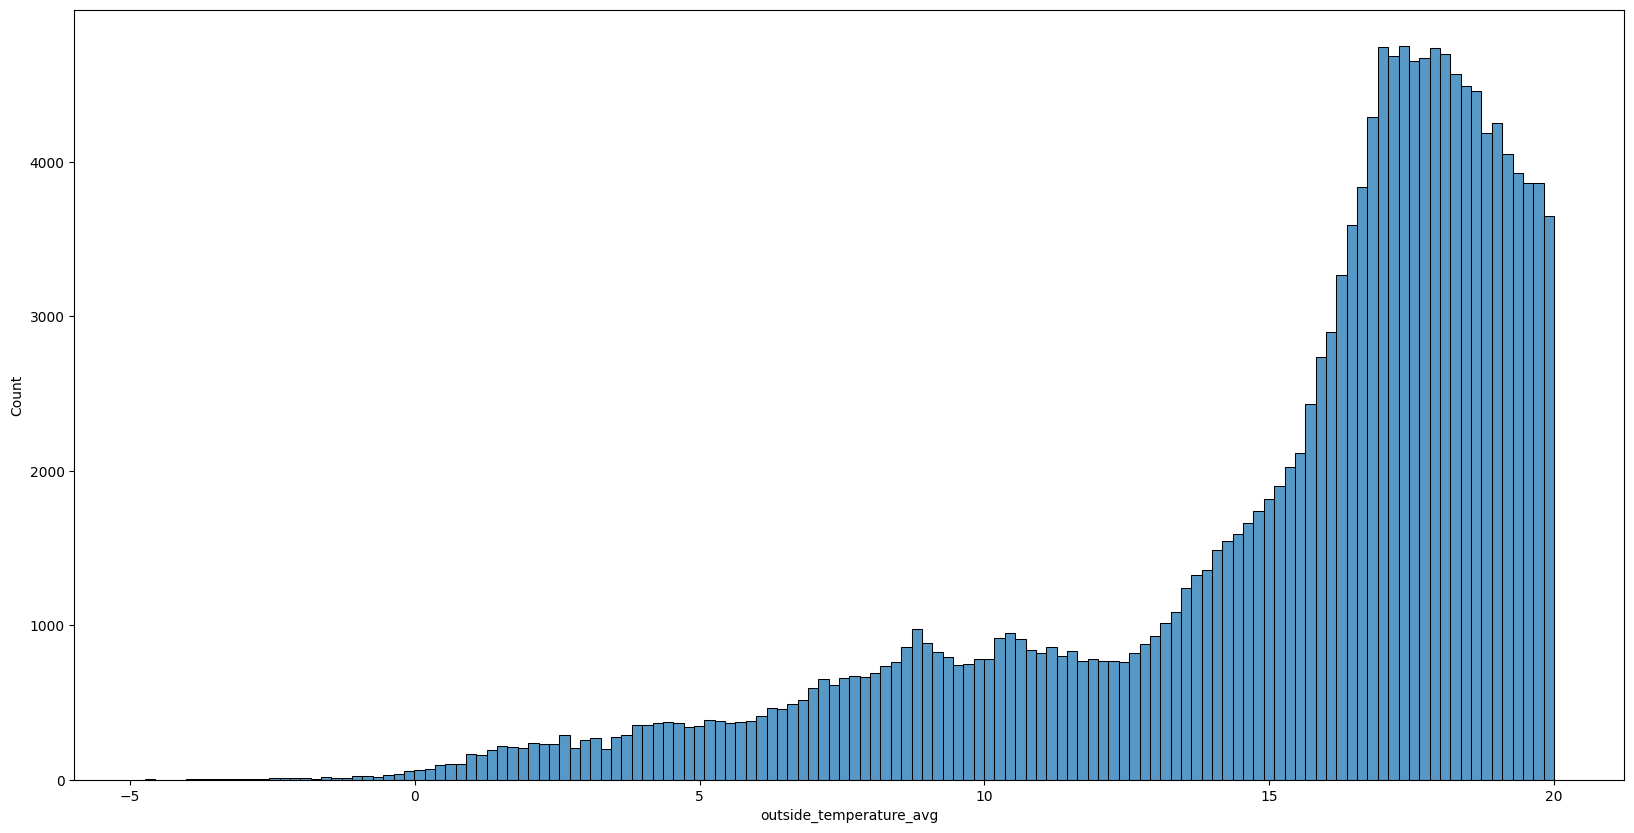

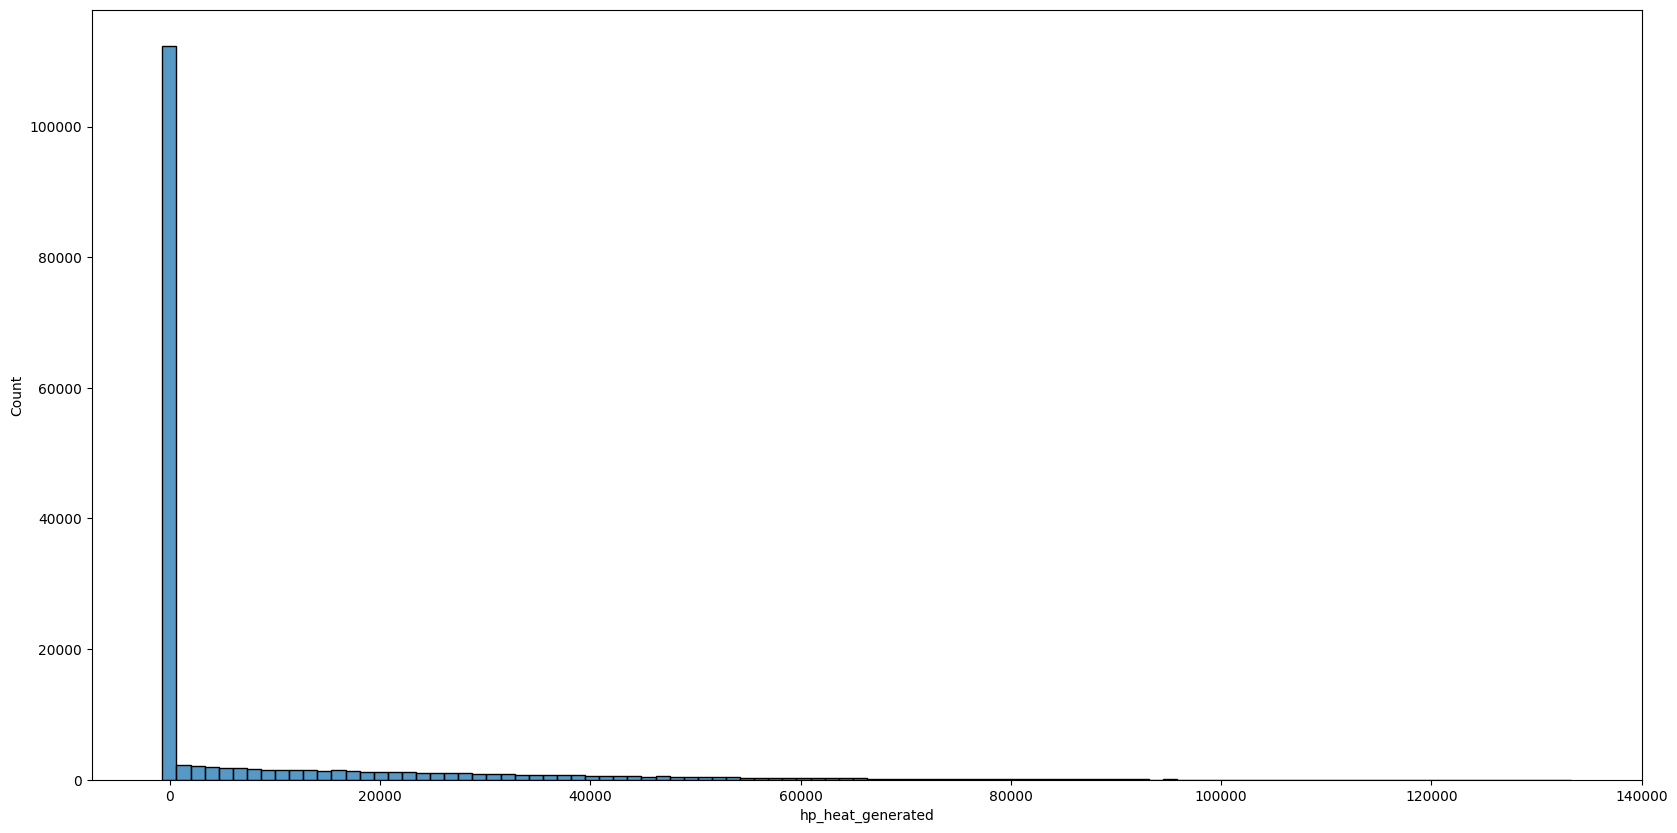

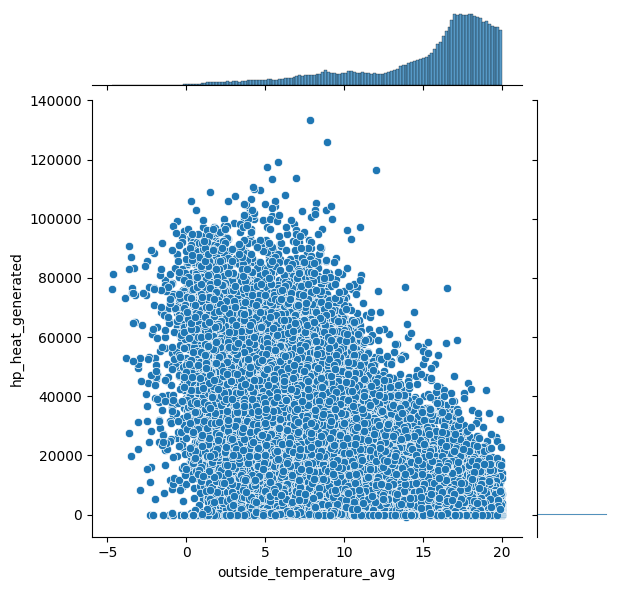

In [24]:
# histograms of temperature
sns.histplot(data=X, x="outside_temperature_avg", multiple="stack")
plt.show()

# histogram of heat generated
sns.histplot(data=y, x="hp_heat_generated", multiple="stack", bins=100)
plt.show()

sns.jointplot(data=df_total, x="outside_temperature_avg", y="hp_heat_generated")
plt.show()

## classification model

In [161]:
# create a boolean y column to determine if heat pump is active
y_bool = (y > 0).astype(int)

In [162]:
# test train split
X_train, X_test, y_bool_train, y_bool_test = train_test_split(X, y_bool, 
                                                    test_size=0.2, 
                                                    random_state=1234)

In [163]:
from sklearn.linear_model import LogisticRegression

# logistic regression including room temperatures and setpoints
logreg_withMonth = LogisticRegression(max_iter=1000, random_state=42)
logreg_withMonth.fit(X_train, y_bool_train)

# Predict on the test set
y_pred = logreg_withMonth.predict(X_test)

# Evaluate the model's performance
train_accuracy = logreg_withMonth.score(X_train, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg_withMonth.predict(X_test)
test_accuracy = logreg_withMonth.score(X_test, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.8952884998010346
test accuracy:  0.8950434533473403


In [93]:
# Extract feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'Feature': logreg_withMonth.columns,
    'Importance': logreg_withMonth.coef_[0]
})

# Sort by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance_sorted = feature_importance.sort_values(by='Abs_Importance', ascending=False)

feature_importance_sorted


,Feature,Importance,Abs_Importance
2,outside_temperature_max,-0.135457,0.135457
0,outside_temperature_avg,-0.130827,0.130827
1,outside_temperature_min,-0.128485,0.128485
5,referentie_warmtevraag_per_m2,0.064498,0.064498
3,month,-0.061914,0.061914
7,oppervlakte,-0.015697,0.015697
10,stookgrens,0.013988,0.013988
18,woning_type_ordinal,0.003222,0.003222
15,Dubbel glas,0.001181,0.001181
13,Dakisolatie,0.001138,0.001138


In [164]:
# model without roomtemp
X_train_no_month = X_train.drop(['month'], axis=1)
X_test_no_month = X_test.drop(['month'], axis=1)

# logistic regression including room temperatures and setpoints
logreg_noMonth = LogisticRegression(max_iter=1000, random_state=42)
logreg_noMonth.fit(X_train_no_month, y_bool_train)

# Predict on the test set
y_pred = logreg_noMonth.predict(X_test_no_month)

# Evaluate the model's performance
train_accuracy = logreg_noMonth.score(X_train_no_month, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg_noMonth.predict(X_test_no_month)
test_accuracy = logreg_noMonth.score(X_test_no_month, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.8926860326303223
test accuracy:  0.8926877407442778


In [95]:
# model without roomtemp and setpoint
X_train_no_setpoint = X_train.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max',
                                    'room_set_temperature_avg',
                                    'room_set_temperature_max',
                                    'room_set_temperature_min'], axis=1)
X_test_no_setpoint = X_test.drop(['room_temperature_avg',
                                    'room_temperature_min',
                                    'room_temperature_max',
                                    'room_set_temperature_avg',
                                    'room_set_temperature_max',
                                    'room_set_temperature_min'], axis=1)

# logistic regression including room temperatures and setpoints
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_no_setpoint, y_bool_train)

# Predict on the test set
y_pred = logreg.predict(X_test_no_setpoint)

# Evaluate the model's performance
train_accuracy = logreg.score(X_train_no_setpoint, y_bool_train)
print('train accuracy: ',train_accuracy)
# Predict on the test set and evaluate the accuracy
y_bool_pred = logreg.predict(X_test_no_setpoint)
test_accuracy = logreg.score(X_test_no_setpoint, y_bool_test)
print('test accuracy: ', test_accuracy)

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train accuracy:  0.8606485005328056
test accuracy:  0.8607440784265968


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## ...

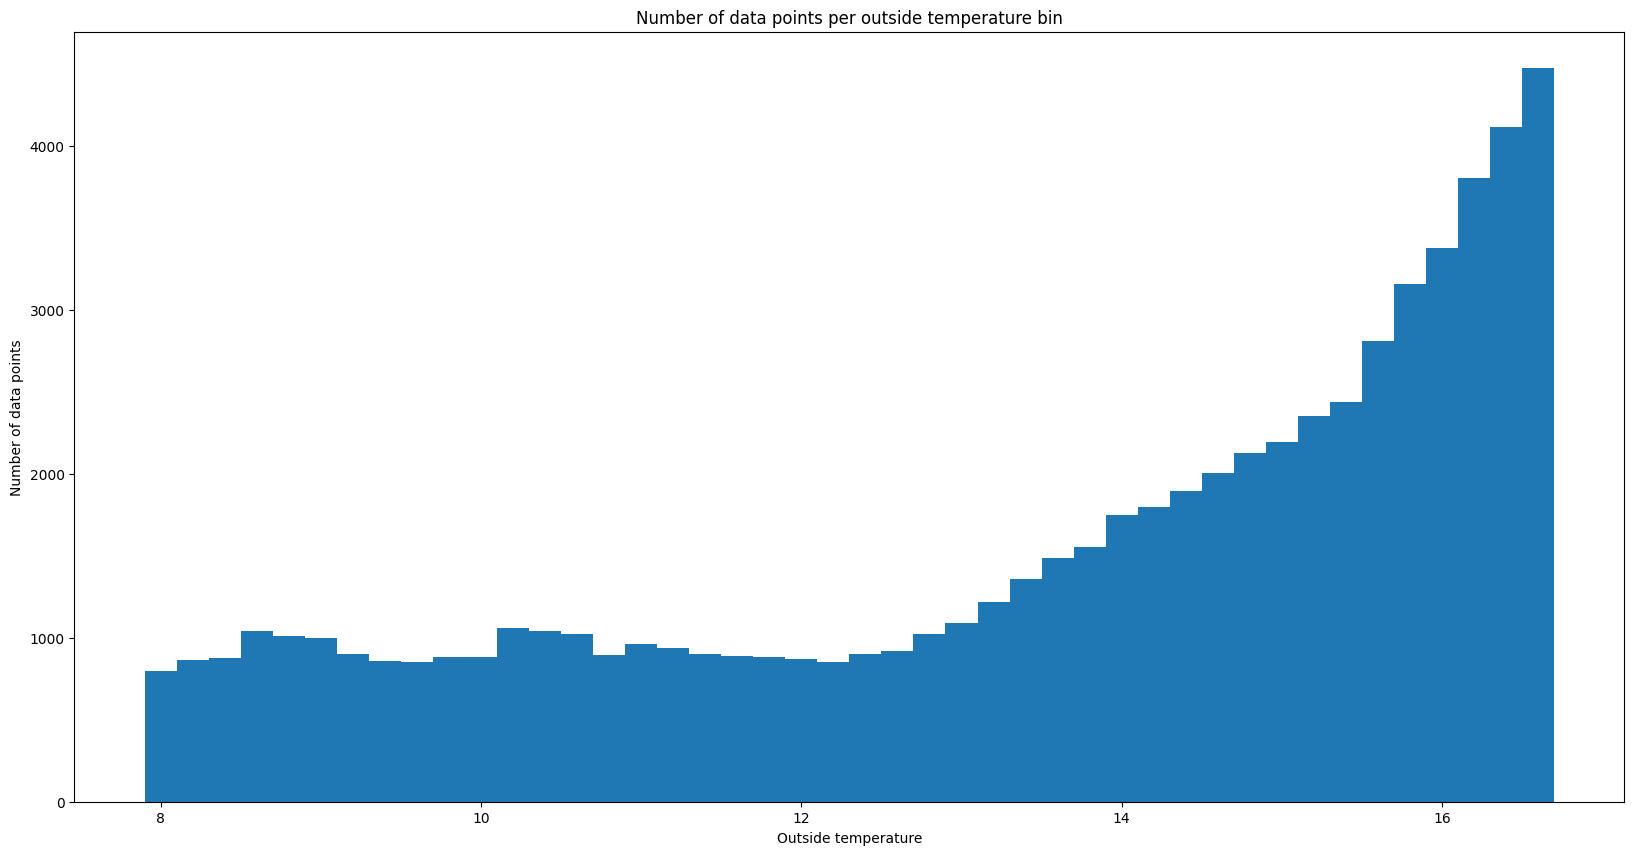

In [96]:
# Define the temperature range with steps of between 8 and 17
temperature_range = np.arange(8, 17, 0.2)
# temperature_range = range(8, 17)

#count  number of samples in each bin in temperature range in X_test
counts = np.histogram(X['outside_temperature_avg'], bins=temperature_range)[0]
# plot number of data points in each bin
plt.bar(temperature_range[:-1], counts, width=0.2)
plt.xlabel('Outside temperature')
plt.ylabel('Number of data points')
plt.title('Number of data points per outside temperature bin')
plt.show()


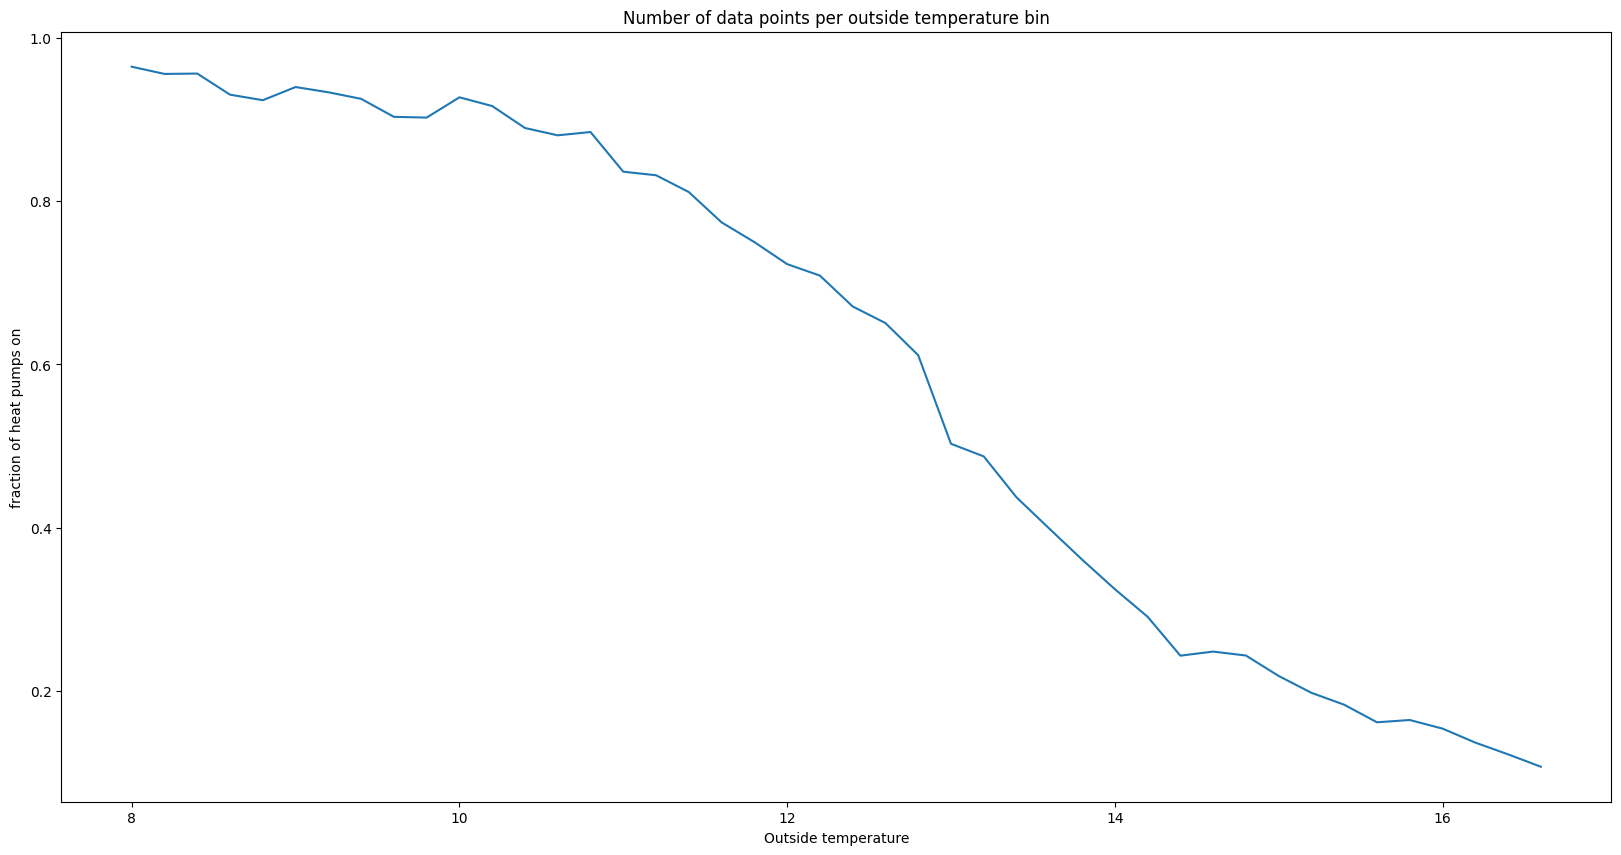

In [97]:
# plot for each temperature the fraction of samples for with heat_delivered > 0
# count number of samples for which heat_delivered > 0
counts_on = np.histogram(df_total[df_total['hp_heat_generated']>0]['outside_temperature_avg'], bins=temperature_range)[0]
counts_tot = np.histogram(df_total['outside_temperature_avg'], bins=temperature_range)[0]
# plot number of data points in each bin
plt.plot(temperature_range[:-1], counts_on/counts_tot)
plt.xlabel('Outside temperature')
plt.ylabel('fraction of heat pumps on')
plt.title('Number of data points per outside temperature bin')
plt.show()

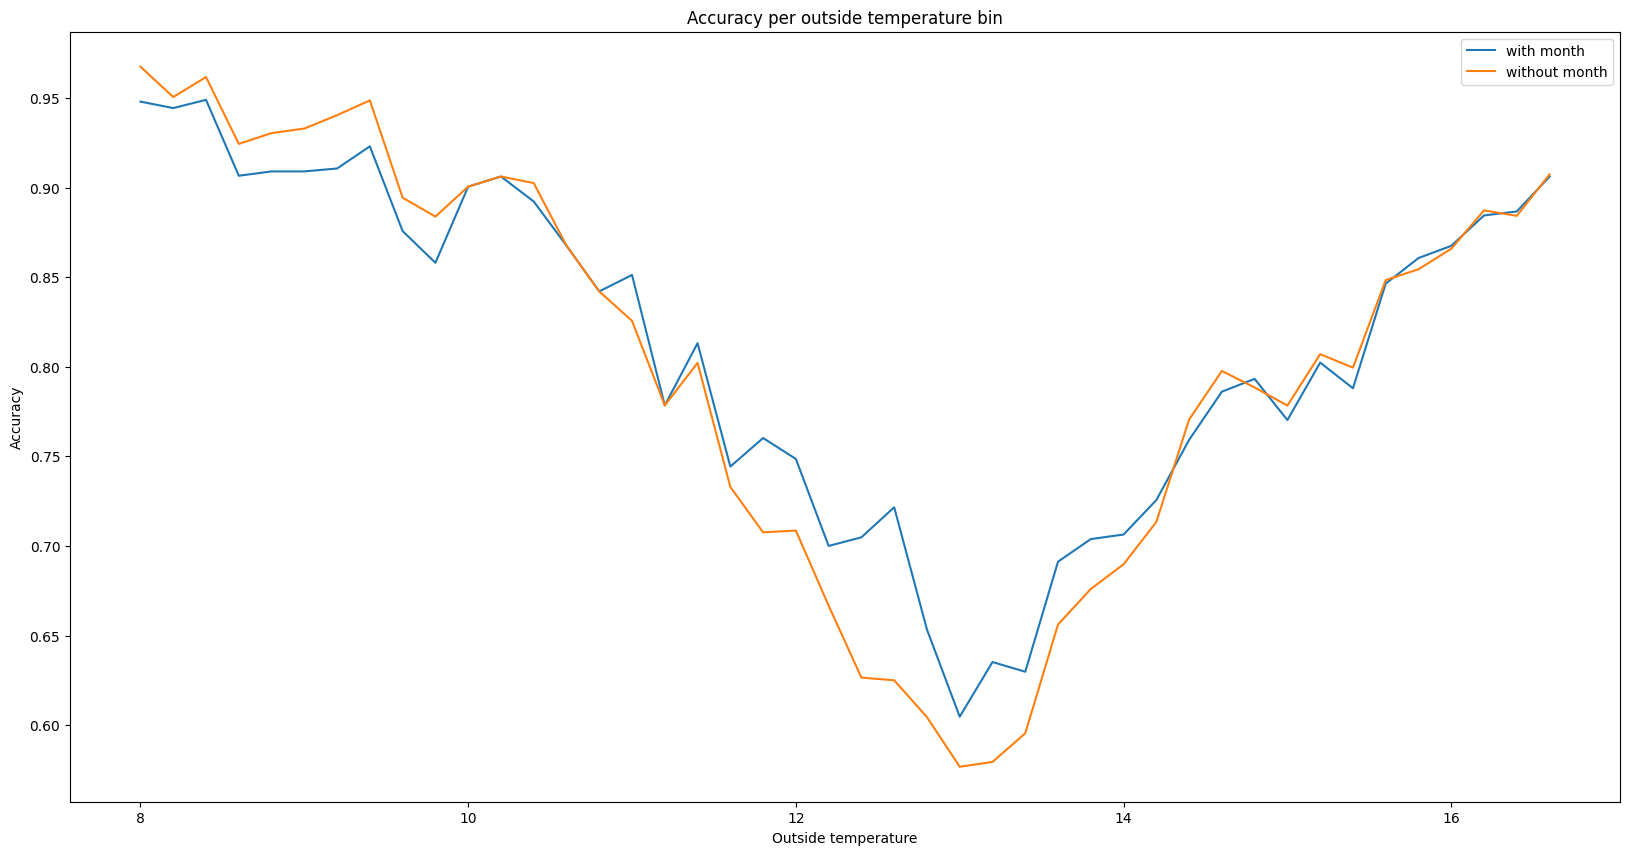

In [168]:
# for each temperature group get the test accuracy of each model
def compute_accuracy_for_temp_range(model, X_test_subset, y_test_subset, temperature_range):
    scores = []
    for i in range(0,len(temperature_range)-1):
        t_min = temperature_range[i]
        t_max = temperature_range[i+1]
        X_temp = X_test_subset[(X_test_subset['outside_temperature_avg']>t_min) 
                               & (X_test_subset['outside_temperature_avg']<=t_max)]
        y_temp = y_test_subset[(X_test_subset['outside_temperature_avg']>t_min) 
                               & (X_test_subset['outside_temperature_avg']<=t_max)]
        if len(X_temp) > 0:
            scores.append(model.score(X_temp, y_temp))
    return scores

# compute accuracy for each temperature range
# scores_1 = compute_accuracy_for_temp_range(logreg, X_test_no_setpoint, y_bool_test, temperature_range)
scores_2 = compute_accuracy_for_temp_range(logreg_withMonth, X_test, y_bool_test, temperature_range)
scores_3 = compute_accuracy_for_temp_range(logreg_noMonth, X_test_no_month, y_bool_test, temperature_range)

# plot accuracy for each temperature range
# plt.plot(temperature_range[:-1], scores_1, label='no roomtemp and setpoint')
plt.plot(temperature_range[:-1], scores_2, label='with month')
plt.plot(temperature_range[:-1], scores_3, label='without month')
plt.xlabel('Outside temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy per outside temperature bin')
plt.legend()
plt.show()





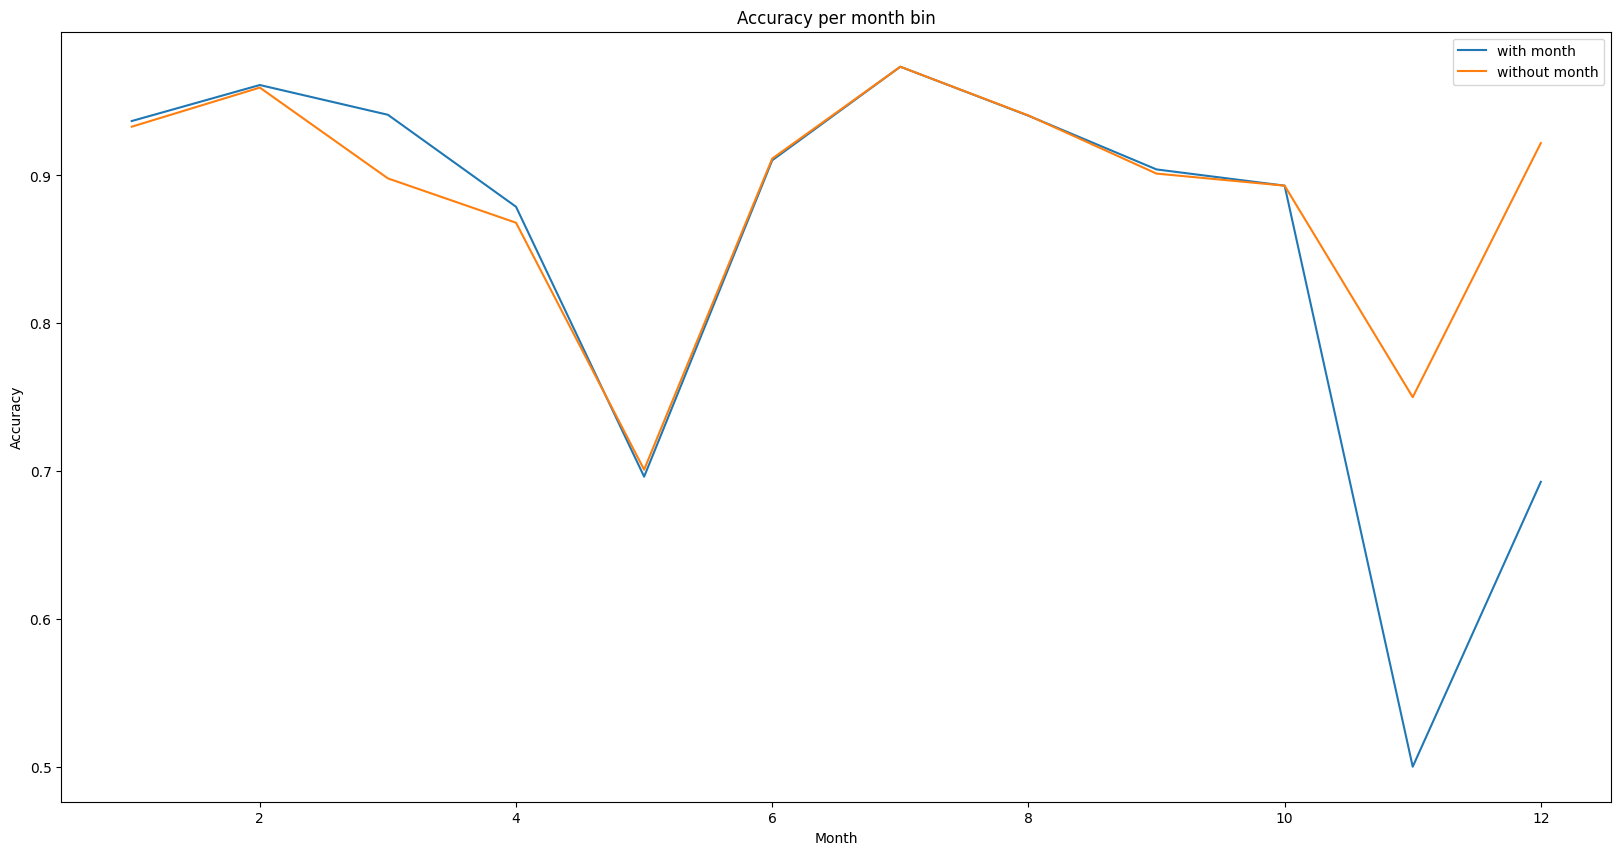

In [177]:
# for each temperature group get the test accuracy of each model
def compute_accuracy_for_month_range(model, X_test_subset, y_test_subset,
                                     month_range, other_subset=None):
    if other_subset is None:
        other_subset = X_test_subset

    scores = []
    for i in month_range:
        X_temp = X_test_subset[(other_subset['month']==i)]
        y_temp = y_test_subset[(other_subset['month']==i)]
        if len(X_temp) > 0:
            scores.append(model.score(X_temp, y_temp))
    return scores

# compute accuracy for each temperature range
month_range = range(1, 13)
# scores_1 = compute_accuracy_for_temp_range(logreg, X_test_no_setpoint, y_bool_test, temperature_range)
scores_2 = compute_accuracy_for_month_range(logreg_withMonth, X_test, y_bool_test, month_range)
scores_3 = compute_accuracy_for_month_range(logreg_noMonth, X_test_no_month, y_bool_test, month_range, other_subset = X_test)

# plot accuracy for each temperature range
# plt.plot(temperature_range[:-1], scores_1, label='no roomtemp and setpoint')
plt.plot(month_range, scores_2, label='with month')
plt.plot(month_range, scores_3, label='without month')
plt.xlabel('Month')
plt.ylabel('Accuracy')
plt.title('Accuracy per month bin')
plt.legend()
plt.show()



In [11]:
X.drop(X[X['outside_temperature_avg']>16].index, inplace=True)

In [16]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1234)

In [21]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators =3,
                             max_depth=8, 
                             random_state=0,
                             criterion='absolute_error')
regr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=3,
                      random_state=0)

Mean Absolute Error: 7053.133095143935
Mean Squared Error: 130284225.42258036


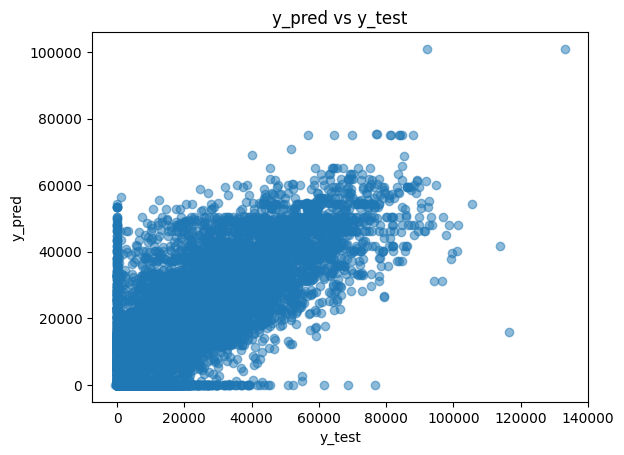

,feature,importance
0,outside_temperature_avg,0.711451
1,aardgas_verbruik,0.079479
2,outside_temperature_max,0.071120
3,month,0.071119
4,Elektriciteit,0.010639
5,referentie_warmtevraag,0.007351
6,oppervlakte,0.006923
7,woning_type_ordinal,0.006162
8,bouwjaar_ordinal,0.004724
9,outside_temperature_min,0.004097


In [22]:
# predict on test set
y_pred = regr.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

# Plotting
feature_importance

In [32]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor

regr_big = RandomForestRegressor(n_estimators =5,
                                max_depth=10, 
                                random_state=0,
                                criterion='squared_error')
regr_big.fit(X_train, y_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=10, n_estimators=5,
                      random_state=0)

Mean Absolute Error: 6691.841727793676
Mean Squared Error: 118467225.62846324


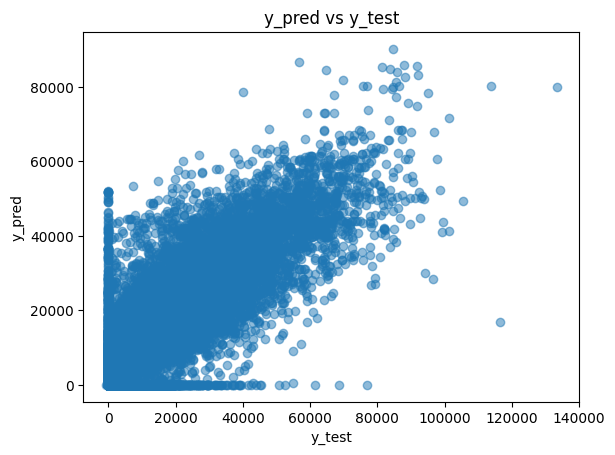

,feature,importance
0,outside_temperature_avg,0.657906
1,aardgas_verbruik,0.082620
2,outside_temperature_max,0.079845
3,month,0.068604
4,Elektriciteit,0.014972
5,referentie_warmtevraag,0.014781
6,oppervlakte,0.011590
7,outside_temperature_min,0.011506
8,woning_type_ordinal,0.008494
9,referentie_warmtevraag_per_m2,0.006307


In [33]:
# predict on test set
y_pred = regr_big.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr_big.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

# Plotting
feature_importance

In [26]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor

regr_bigg = RandomForestRegressor(n_estimators=10,
                                max_depth=15, 
                                random_state=0,
                                criterion='absolute_error')
regr_bigg.fit(X_train, y_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=15, n_estimators=10,
                      random_state=0)

Mean Absolute Error: 6078.971818501743
Mean Squared Error: 98792905.2003885


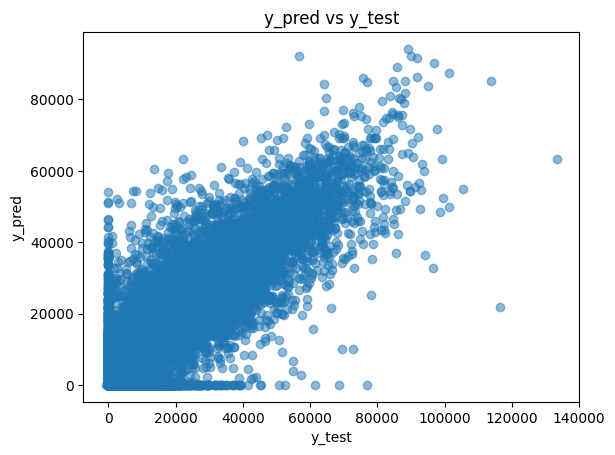

,feature,importance
0,outside_temperature_avg,0.560102
1,outside_temperature_max,0.085303
2,aardgas_verbruik,0.076972
3,month,0.062804
4,outside_temperature_min,0.034485
5,Elektriciteit,0.028413
6,referentie_warmtevraag,0.025753
7,oppervlakte,0.021262
8,referentie_warmtevraag_per_m2,0.013736
9,woning_type_ordinal,0.012099


In [27]:
# predict on test set
y_pred = regr_bigg.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr_bigg.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

# Plotting
feature_importance

In [28]:
# pickle dump model

pickle.dump(regr_bigg, open('./data/export/rf_1015_withMonths.sav', 'wb'))


## training two models: heat produced and electricity consumed

In [161]:
X_train, X_test, hp_heat_generated_train, hp_heat_generated_test = (
    train_test_split(X, hp_heat_generated, test_size=0.2, random_state=1234))

In [162]:
regr_heat = RandomForestRegressor(n_estimators=10,
                                    max_depth=18, 
                                    random_state=0,
                                    criterion='absolute_error')
regr_heat.fit(X_train, hp_heat_generated_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=18, n_estimators=10,
                      random_state=0)

Mean Absolute Error: 6197.469501476432
Mean Squared Error: 98351358.60254192


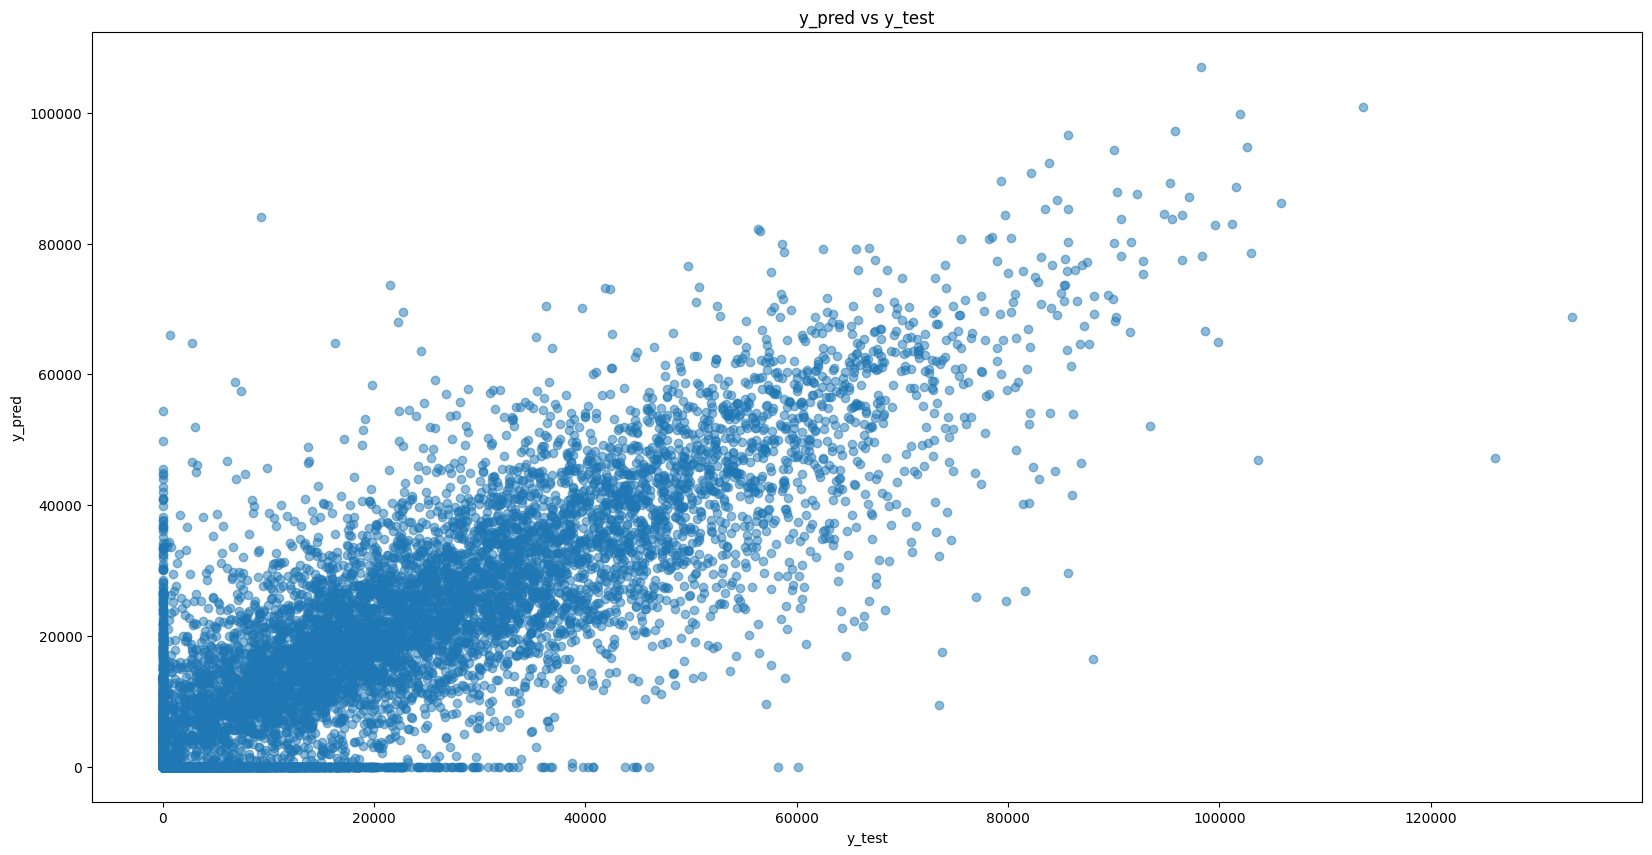

,feature,importance
0,knmi_max_temp,0.472077
1,aardgas_verbruik,0.077628
2,month,0.065506
3,room_set_temperature_avg_median,0.046376
4,knmi_global_radiation,0.033472
5,Elektriciteit,0.027436
6,knmi_avg_temp,0.026760
7,knmi_min_temp,0.026168
8,referentie_warmtevraag,0.025964
9,room_set_temperature_min_median,0.019956


In [163]:
# 1018 with knmi (no room setpoint) -> MAE 5930, MSE 94448290

pickle.dump(regr_heat, open('./data/export/rfh_1018_withroomtemp.sav', 'wb'))
# predict on test set
y_pred = regr_heat.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(hp_heat_generated_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(hp_heat_generated_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr_heat.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(hp_heat_generated_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

feature_importance



In [164]:
X_train, X_test, hp_energy_consumed_train, hp_energy_consumed_test = (
    train_test_split(X, hp_energy_consumed, test_size=0.2, random_state=1234))

In [165]:
regr_energy = RandomForestRegressor(n_estimators=10,
                                    max_depth=18, 
                                    random_state=0,
                                    criterion='absolute_error')
regr_energy.fit(X_train, hp_energy_consumed_train.values.ravel())

RandomForestRegressor(criterion='absolute_error', max_depth=18, n_estimators=10,
                      random_state=0)

Mean Absolute Error: 1646.1705040828037
Mean Squared Error: 7705349.256452274


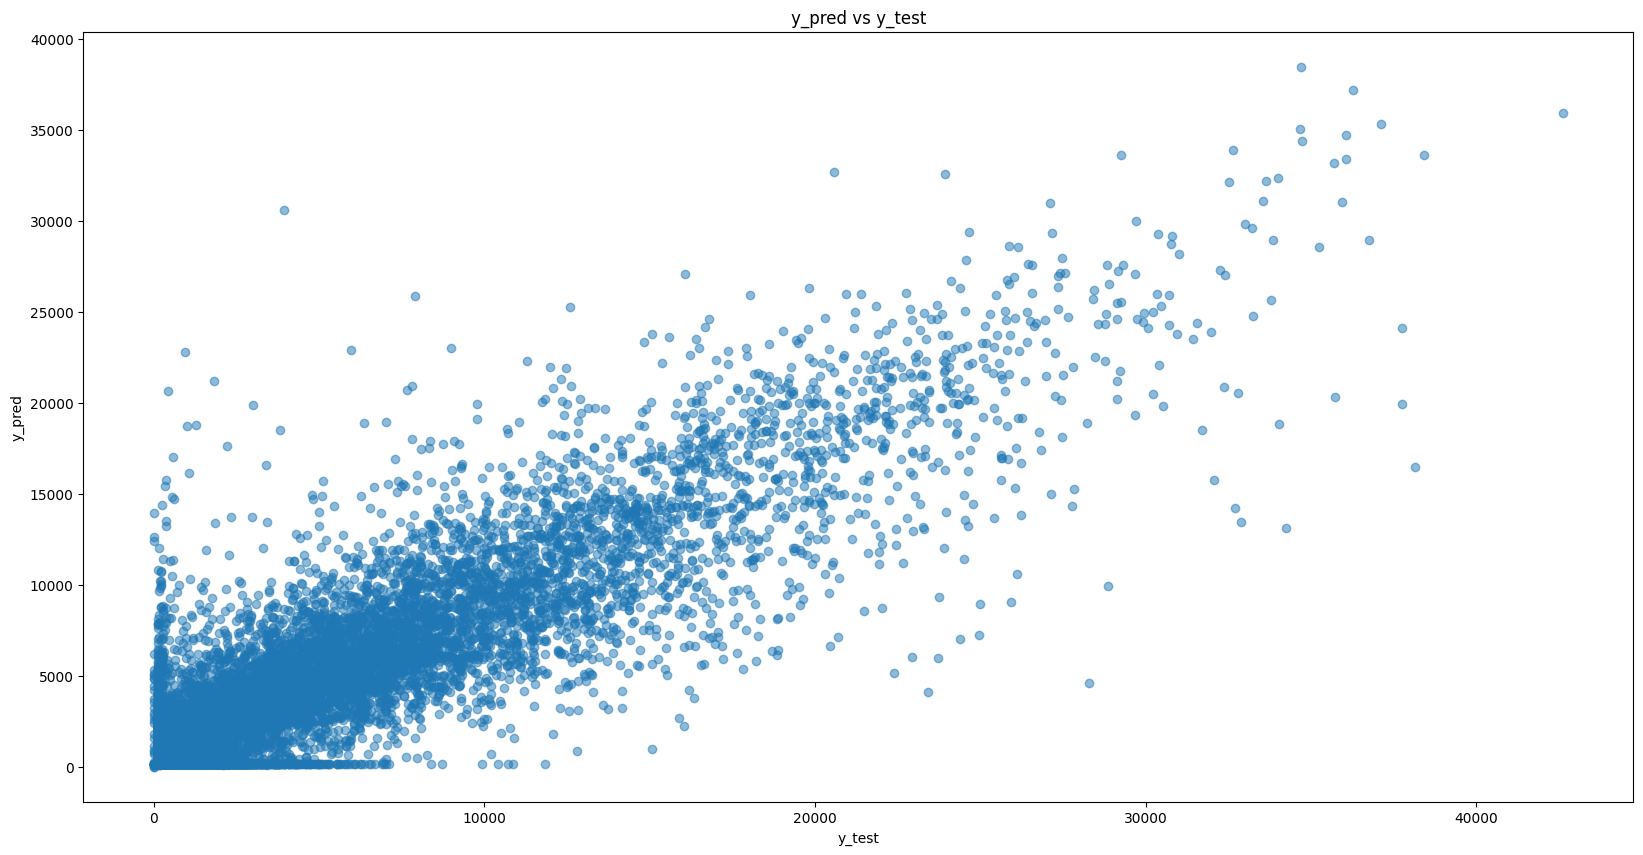

,feature,importance
0,knmi_max_temp,0.392251
1,knmi_avg_temp,0.100830
2,month,0.083744
3,aardgas_verbruik,0.069690
4,room_set_temperature_avg_median,0.047500
5,knmi_global_radiation,0.030257
6,Elektriciteit,0.028524
7,referentie_warmtevraag,0.025340
8,knmi_min_temp,0.024161
9,oppervlakte,0.019723


In [166]:
# 1018 model withknmi: MAE: 1585, MSE: 7414308
# 1018 model with knmi & roomtemp: 
pickle.dump(regr_bigg, open('./data/export/rfe_1018_withroomtemp.sav', 'wb'))

# predict on test set
y_pred = regr_energy.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(hp_energy_consumed_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(hp_energy_consumed_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr_energy.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(hp_energy_consumed_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

# Plotting
feature_importance
